# Creator:
### Najeeb Zaidi
### Github: https://github.com/snajeebz
### zaidi.nh@gmail.com
### Contributors: 
1. https://github.com/snajeebz
2. https://github.com/qinajeeb
## Dataset Source: 
1. https://www.kaggle.com/competitions/titanic

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf
#Disable warning
import warnings
warnings.filterwarnings("ignore")

print(f"Tensor Flow Version: {tf.__version__}")

Tensor Flow Version: 2.13.0


# Importing the Dataset

In [17]:
try:   #for Local Environment
    train_df = pd.read_csv("Dataset/train.csv")
    serving_df = pd.read_csv("Dataset/test.csv")
except: #for Kaggle Environment
    train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
    serving_df = pd.read_csv("/kaggle/input/titanic/test.csv")

train_df.head(100)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
98,99,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,NaN,S


# Strategy:
1. Data Preparation and Scikit Learn Algo implementation
2. Model and Hyper Parameter Tuning
3. Tensorflow Models implementation
4. Tensorflow Models and Hyper-Parameters Tuning

## 1. Data Preparation and Scikit Learn Algo implementation

### Steps:
1. Dataset EDA
2. Data Wrangling
3. Test Train Dataset preparation for scikit-Learn
4. Scikit Learn ML Model Plus Hyper Parameters Tuning
5. Submission of the Best Results.

## 1. Dataset EDA

In [4]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Observations:
1. Cabin has got 687 nulls which is more than 75% of the rows. So I guess it will be better to not use cabin as a feature for our model.
2. Age has around 20% nulls. So we will try the best to fill them up.

## Let's dig deep into Age

In [5]:
print("Group by Parch: \n",train_df['Age'].isna().groupby(train_df['Parch']).value_counts())
print("Group by Sex: \n",train_df['Age'].isna().groupby(train_df['Sex']).value_counts())
print("Group by SibSp: \n",train_df['Age'].isna().groupby(train_df['SibSp']).value_counts())
print("Group by Pclass: \n",train_df['Age'].isna().groupby(train_df['Pclass']).value_counts())



Group by Parch: 
 Parch  Age  
0      False    521
       True     157
1      False    110
       True       8
2      False     68
       True      12
3      False      5
4      False      4
5      False      5
6      False      1
Name: count, dtype: int64
Group by Sex: 
 Sex     Age  
female  False    261
        True      53
male    False    453
        True     124
Name: count, dtype: int64
Group by SibSp: 
 SibSp  Age  
0      False    471
       True     137
1      False    183
       True      26
2      False     25
       True       3
3      False     12
       True       4
4      False     18
5      False      5
8      True       7
Name: count, dtype: int64
Group by Pclass: 
 Pclass  Age  
1       False    186
        True      30
2       False    173
        True      11
3       False    355
        True     136
Name: count, dtype: int64


## Observation
1. Out the Nans of age 16% are female.
2. Out the Nans of age 21% are male.

# Let's impute the nulls.

### You can refer to the [Imputating the Nans by ML](https://www.kaggle.com/code/najeebz/titanic-deep-learning) results on that notebook:
> It resulted in 80% Accurate Results.

In [82]:
df = train_df[['Survived','Age','SibSp', 'Parch', 'Fare','PassengerId', 'Sex','Pclass']]
df=pd.get_dummies(df, columns=['Sex'])
df.head()


,Survived,Age,SibSp,Parch,Fare,PassengerId,Pclass,Sex_female,Sex_male
0,0,22.0,1,0,7.2500,1,3,False,True
1,1,38.0,1,0,71.2833,2,1,True,False
2,1,26.0,0,0,7.9250,3,3,True,False
3,1,35.0,1,0,53.1000,4,1,True,False
4,0,35.0,0,0,8.0500,5,3,False,True


In [83]:

def clustering(df):
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler    
    X=df[['SibSp', 'Parch', 'Fare','Sex_female', 'Sex_male','Pclass']]
#Scalling the data
    scaler=StandardScaler()
    X_scaled=scaler.fit_transform(X)
#perform clustering
    model=KMeans(n_clusters=5,algorithm="elkan" )
    model.fit(X_scaled)
    return model.labels_
def Impute_clusters(df):
    print('Nans before operation: ', df['Age'].isnull().sum())
    mean=df['Age'].groupby(df['clusters']).mean()
    for m in range(1,6):
        df['Age'][(df['clusters']==m) & (df['Age'].isnull()==True)]=mean[m]
    df['clusters']=df['clusters']/5
    print('Nans After operation: ', df['Age'].isnull().sum())
    return df
df['clusters']=np.nan   
df['clusters']=(clustering(df)+1)
df=Impute_clusters(df)


Nans before operation:  177
Nans After operation:  0


In [84]:
df

,Survived,Age,SibSp,Parch,Fare,PassengerId,Pclass,Sex_female,Sex_male,clusters
0,0,22.000000,1,0,7.2500,1,3,False,True,0.8
1,1,38.000000,1,0,71.2833,2,1,True,False,0.6
2,1,26.000000,0,0,7.9250,3,3,True,False,0.4
3,1,35.000000,1,0,53.1000,4,1,True,False,0.6
4,0,35.000000,0,0,8.0500,5,3,False,True,0.8
...,...,...,...,...,...,...,...,...,...,...
886,0,27.000000,0,0,13.0000,887,2,False,True,0.2
887,1,19.000000,0,0,30.0000,888,1,True,False,0.4
888,0,25.684524,1,2,23.4500,889,3,True,False,0.4
889,1,26.000000,0,0,30.0000,890,1,False,True,0.2


In [85]:
figure= px.imshow(df.corr(), text_auto=True, width=1200, height=1200)
figure.show()

Upper Outliers: Series([], Name: Age, dtype: float64)
Lower Outliers: Series([], Name: Age, dtype: float64)


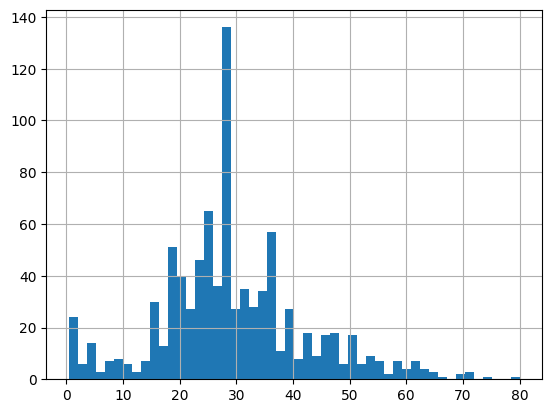

In [86]:
df['Age'].hist(bins=50)
print('Upper Outliers:',df['Age'][df['Age']>80])
print('Lower Outliers:',df['Age'][df['Age']<0])

Some noticeable correlation between Sibsp, Parch with Age. I guess if we apply Machine Learning Algorithm, we can get some fruitful model to fill the Nans of the age.

# Preparing Training Dataset

In [87]:
X=df[['Age', 'SibSp', 'Parch','Fare','Sex_female', 'Sex_male','Pclass', 'clusters']]
y=df[['Survived']]

In [88]:
def scale(X):
    from sklearn import preprocessing
    scaled=preprocessing.StandardScaler()
    scaler=scaled.fit(X)
    X=scaler.transform(X)
    return X

In [89]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(scale(X),y,train_size=0.8, random_state=42)

# Evaluation of the Training Model

In [90]:
def evaluate(y_test,ypred):
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    print("Accuracy: ",accuracy_score(y_test,y_pred)) 
    print("Precision Score : ", precision_score(y_test,y_pred)) #precision measures the proportion of true positive predictions among all positive instances. how many of survived predicted actually survived, doesn't verifies 0's 70 survived as preicted whereas actually 92 survived so 70/92 will be the precision.  if we predicted 70 survived, so presion will tell how many of those 70 predicted survived matches the actual row by row data. It checkes all positives and verifies if the answer is true for each row?
    print("Recall Score: ", recall_score(y_test,y_pred, average='macro')) #Recall measures the proportion of true positive predictions among all actual positive instalnces. If we predicted 100 survived correctly whereas actually 100 survived out of which 67 predicted correctly so recall will be 0.67
    print("F1 Score: ",f1_score(y_test,y_pred)) #mean of recall and precision
    cm = confusion_matrix(y_test, y_pred)
    figure= px.imshow(cm,text_auto=True, width=1200, height=1200)
    figure.show()

# Training KNN Classifier

In [91]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
evaluate(y_test,y_pred)

Accuracy:  0.7877094972067039
Precision Score :  0.7647058823529411
Recall Score:  0.7751608751608752
F1 Score:  0.7323943661971832


# Training Random Forest Classifier

In [92]:
from sklearn.ensemble import RandomForestClassifier
rf =RandomForestClassifier(n_jobs=-1,verbose=1) 
print ('Training the model')
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
evaluate(y_test,y_pred)

Training the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s


Accuracy:  0.7877094972067039
Precision Score :  0.7432432432432432
Recall Score:  0.7811454311454311
F1 Score:  0.7432432432432431


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


# Training MLP Classifier

In [93]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', 
              max_iter =1000, 
              alpha=10, 
              hidden_layer_sizes=10, 
              random_state=5,
              activation='identity',
              batch_size=360, 
              learning_rate='adaptive', 
              verbose=0,
              early_stopping=0, 
              n_iter_no_change=100)

print ('Training the model')
clf.fit(X_train,y_train)
print(clf.score(X_train,y_train))
y_pred=clf.predict(X_test)
evaluate(y_test,y_pred)

Training the model
0.8019662921348315
Accuracy:  0.7877094972067039
Precision Score :  0.7727272727272727
Recall Score:  0.7731660231660231
F1 Score:  0.7285714285714284


# Training DL Model

In [102]:
#model_nn=tf.keras.Sequential([
#  tf.keras.layers.Dense(1281,input_shape=[X_train.shape[1]]),
#  tf.keras.layers.Dense(512,activation=tf.nn.relu, use_bias=False),
#  tf.keras.layers.Dense(256,activation=tf.nn.relu, use_bias=True),
#  tf.keras.layers.Dense(1, activation='softmax')
#])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1281)              11529     
                                                                 
 dense_1 (Dense)             (None, 512)               655872    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 798986 (3.05 MB)
Trainable params: 798986 (3.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Function to Evaluate Training

In [118]:
def plot_history(history):
    hist=pd.DataFrame(history.history)
    hist['epoch']=history.epoch
    hist1=[]
#hist1=hist.tail(550)
    hist1=hist
#sns.lineplot(data=histsamp, y='val_mse', x='epoch')

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist1['epoch'],hist1['accuracy'], label='Train Accuracy')
    plt.plot(hist1['epoch'], hist1['val_accuracy'], label='Val_Accuracy')
    plt.legend()
#plt.ylim([0, 0.2])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist1['epoch'],hist1['Brier score'], label='Train Error')
    plt.plot(hist1['epoch'], hist1['val_Brier score'], label='Val_Error')
    plt.legend()

In [125]:
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model_nn= tf.keras.Sequential([
              tf.keras.layers.Dense(512,activation=tf.nn.relu,input_shape=(X_train.shape[1],)),
              tf.keras.layers.Dense(256, activation=tf.nn.relu),
              tf.keras.layers.Dense(128, activation=tf.nn.relu),
              tf.keras.layers.Dense(64, activation=tf.nn.relu),
              tf.keras.layers.Dense(32, activation=tf.nn.tanh),
              tf.keras.layers.Dense(16, activation=tf.nn.tanh),
              tf.keras.layers.Dense(1, activation=tf.nn.softmax)
  ])
model_nn.summary()
model_nn.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=METRICS)



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 512)               4608      
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 16)                528       
                                                                 
 dense_29 (Dense)            (None, 1)                

6/6 [==============================] - 0s 6ms/step - loss: 8.9451 - cross entropy: 8.9451 - Brier score: 0.5866 - tp: 74.0000 - fp: 105.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.4134 - precision: 0.4134 - recall: 1.0000 - auc: 0.5000 - prc: 0.4134
Test accuracy: [8.945083618164062, 8.945083618164062, 0.5865920782089233, 74.0, 105.0, 0.0, 0.0, 0.4134078323841095, 0.4134078323841095, 1.0, 0.5, 0.4134078323841095]
6/6 [==============================] - 0s 2ms/step


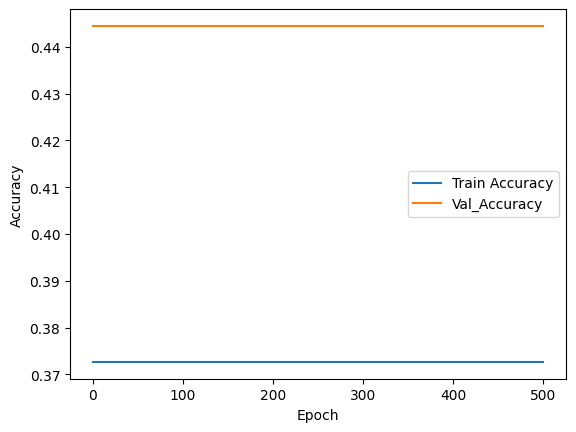

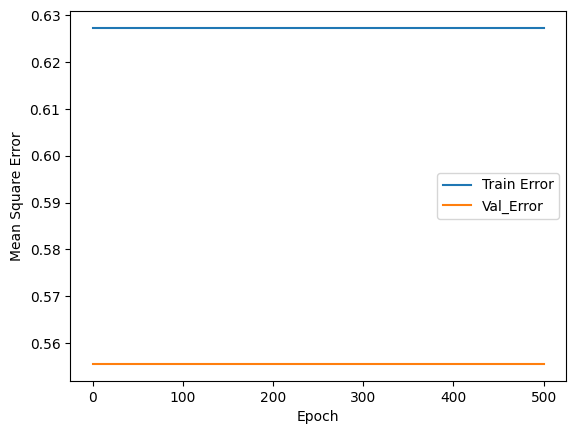

In [126]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='Brier score',
                                            min_delta=0,
                                            patience=500,
                                             verbose=0, mode='auto')
X_train = pd.DataFrame(X_train).astype('float32')
X_test = pd.DataFrame(X_test).astype('float32')
history=model_nn.fit(X_test,y_train, verbose=0, epochs=1000, validation_split=0.1, batch_size=32,callbacks=[early_stop])
#evaluate the model
print('Test accuracy:', model_nn.evaluate(X_test,y_test))
plot_history(history)
y_pred=model_nn.predict(X_test)
#y_pred

## Observations:
- All the models return 0.8 accuracy with not much differnce. 
- However, the best results are obtained by KNN Classifier.

# Preparing the Test Data

In [96]:
df = serving_df[['Age','SibSp', 'Parch', 'Fare','PassengerId', 'Sex','Pclass']]
print('Before Processing: \n', df.isnull().sum())
df=pd.get_dummies(df, columns=['Sex'])
df['Fare'].fillna(df['Fare'].median(),inplace=True)
df['clusters']=np.nan
df['clusters']=clustering(df)+1
df=Impute_clusters(df)
print('After Processing: \n', df.isnull().sum())


Before Processing: 
 Age            86
SibSp           0
Parch           0
Fare            1
PassengerId     0
Sex             0
Pclass          0
dtype: int64
Nans before operation:  86
Nans After operation:  0
After Processing: 
 Age            0
SibSp          0
Parch          0
Fare           0
PassengerId    0
Pclass         0
Sex_female     0
Sex_male       0
clusters       0
dtype: int64


# Preparing the Results for Submission

In [97]:
X=df[['Age', 'SibSp', 'Parch','Fare','Sex_female', 'Sex_male','Pclass', 'clusters']]
result=pd.DataFrame(columns=['PassengerId', 'Survived'])
result['PassengerId']=serving_df['PassengerId']
result['Survived']=clf.predict(scale(X))

In [98]:
result=result.set_index('PassengerId')
result

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [99]:
result.to_csv('submission.csv')